# Machine Learning methods on Mauna Loa CO2 data

## Import required libraries and packages

In [85]:
# 1) Standard library imports
import datetime

# 2) Third party library imports
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 3) Local application/library imports

## Load input data

In [86]:
co2 = fetch_openml(data_id=41187, as_frame=True, parser="pandas")
co2.frame.head()

,year,month,day,weight,flag,station,co2
0,1958,3,29,4,0,MLO,316.1
1,1958,4,5,6,0,MLO,317.3
2,1958,4,12,4,0,MLO,317.6
3,1958,4,19,6,0,MLO,317.5
4,1958,4,26,2,0,MLO,316.4


## Data preprocessing

In [87]:
# Do necessary data type conversion and extract only required columns
co2_data = co2.frame
co2_data["date"] = pd.to_datetime(co2_data[["year", "month", "day"]])
co2_data = co2_data[["date", "co2"]].set_index("date")
co2_data.head()

,co2
date,
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


In [88]:
# Print minimum and maximum time stamps
co2_data.index.min(), co2_data.index.max()

(Timestamp('1958-03-29 00:00:00'), Timestamp('2001-12-29 00:00:00'))

### Visualize raw data

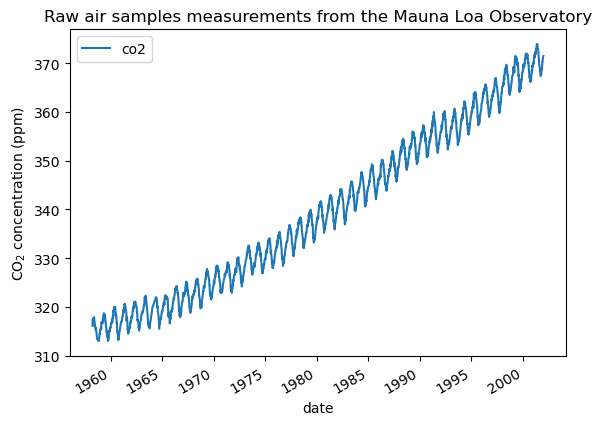

In [89]:
co2_data.plot()
plt.ylabel("CO$_2$ concentration (ppm)")
_ = plt.title("Raw air samples measurements from the Mauna Loa Observatory")

### Resample data to take monthly averages

In [90]:
# Resample data monthly
co2_data = co2_data.resample("M").mean().dropna(axis="index", how="any")

### Split Data for Cross Validation

In [91]:
RANDOM_SEED = 42  # Ensures reproducibility of split
co2_train, co2_validation = train_test_split(
    co2_data, test_size=0.25, shuffle=False, random_state=RANDOM_SEED
)

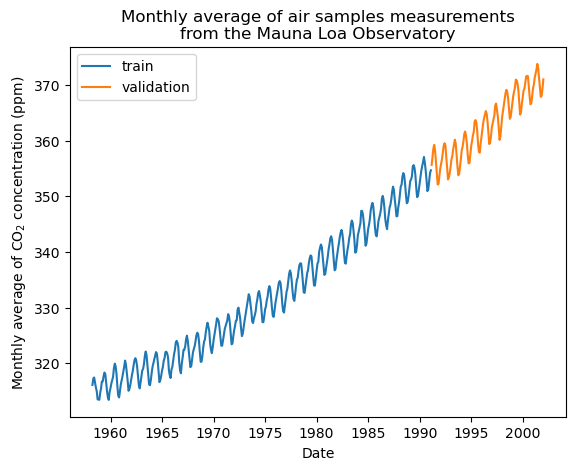

In [92]:
plt.plot(co2_train)
plt.plot(co2_validation)
plt.ylabel("Monthly average of CO$_2$ concentration (ppm)")
plt.xlabel("Date")
_ = plt.title(
    "Monthly average of air samples measurements\nfrom the Mauna Loa Observatory"
)
plt.legend(["train", "validation"])

### Split input features and target variable

In [93]:
X = (co2_train.index.year + co2_train.index.month / 12).to_numpy().reshape(-1, 1)
y = co2_train["co2"].to_numpy()

## Model Training

### Decision Tree

#### Predict Absolute CO2 levels

In [94]:
# Train models
decision_tree_1 = tree.DecisionTreeRegressor(max_depth=2)
decision_tree_2 = tree.DecisionTreeRegressor(max_depth=11)
decision_tree_1.fit(X, y)
decision_tree_2.fit(X, y)

DecisionTreeRegressor(max_depth=11)

In [95]:
# Make predictions on validation data
X_validation = (
    (co2_validation.index.year + co2_validation.index.month / 12)
    .to_numpy()
    .reshape(-1, 1)
)
y_validation = co2_validation["co2"].to_numpy()

y_predictions_1 = decision_tree_1.predict(X_validation)
y_predictions_2 = decision_tree_2.predict(X_validation)

In [96]:
# Calculate evaluation metrics
mse_of_regr_1 = mean_squared_error(y_validation, y_predictions_1)
mse_of_regr_2 = mean_squared_error(y_validation, y_predictions_2)

print(f"Validation MSE for Decision Tree with depth 2: {mse_of_regr_1:.4f}")
print(f"Validation MSE for Decision Tree with depth 11: {mse_of_regr_2:.4f}")

Validation MSE for Decision Tree with depth 2: 210.6841
Validation MSE for Decision Tree with depth 11: 96.5067


In [97]:
# Get dates from 1958 to 2023
today = datetime.datetime.now()
current_month = today.year + today.month / 12
X_test = np.linspace(start=1958, stop=current_month, num=1_000).reshape(-1, 1)

In [98]:
# Make predictions
y_1 = decision_tree_1.predict(X_test)
y_2 = decision_tree_2.predict(X_test)

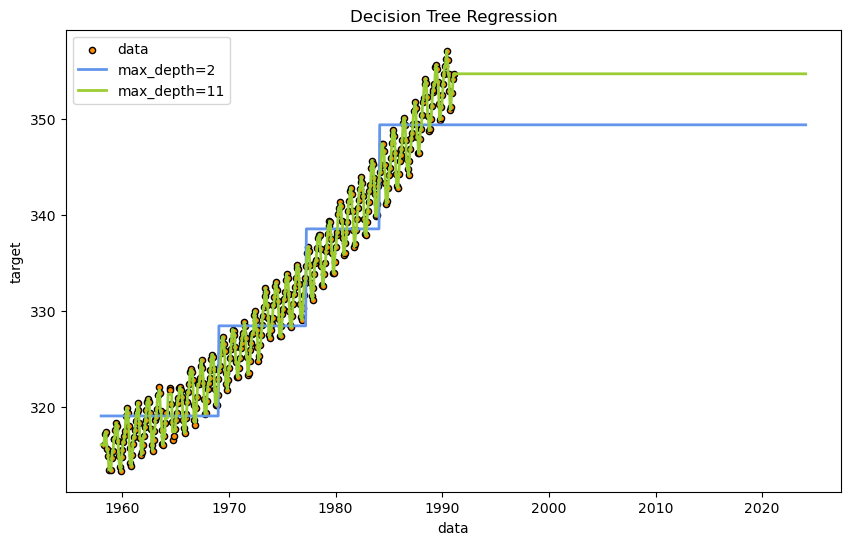

In [99]:
plt.figure(figsize=(10, 6))
plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")

# Plot predictions of decision tree 1
plt.plot(
    X_test,
    y_1,
    color="cornflowerblue",
    label=f"max_depth={decision_tree_1.max_depth}",
    linewidth=2,
)

# Plot predictionso f decision tree 2
plt.plot(
    X_test,
    y_2,
    color="yellowgreen",
    label=f"max_depth={decision_tree_2.max_depth}",
    linewidth=2,
)

plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

#### Predict CO2 level differences using Decision Trees (Autoregressive Model)

In [100]:
def preprocess_data(input_data, train_window, scaler, forecast_window=1, is_test=False):
    """
    Function that takes data and reformat for the autoregressive task
    """
    
    # Take derivative
    input_data = np.concatenate([[0], np.diff(input_data)])

    # Scale values
    scaler = scaler

    # Important: Not to leak information from training data to test data (clean evaluation)
    if is_test:
        normalized_data = scaler.transform(input_data.reshape(-1, 1)).reshape(-1)
    else:
        normalized_data = scaler.fit_transform(input_data.reshape(-1, 1)).reshape(-1)

    # Create input-output pairs
    in_seq = []
    out_seq = []
    L = len(normalized_data)

    # Reformat training data for autoregressive task
    for i in range(0, L - train_window - forecast_window, forecast_window):
        train_seq = normalized_data[i : i + train_window]
        train_label = normalized_data[
            i + train_window : i + train_window + forecast_window
        ]

        in_seq.append(train_seq)
        out_seq.append(train_label)
        
    return normalized_data, in_seq, out_seq, scaler

In [101]:
# Paramters
TRAIN_WINDOW = 50 # No of months looked back
FORECAST_WINDOW = 1 # No of months predicted forward
standardScaler = StandardScaler()

In [102]:
# Create training data for autoregrssive task
normalized_train, X_train, y_train, scaler = preprocess_data(
    list(co2_train["co2"]),
    TRAIN_WINDOW,
    standardScaler,
    forecast_window=FORECAST_WINDOW,
    is_test=False,
)

In [103]:
# Train models
decistion_tree_3 = tree.DecisionTreeRegressor(max_depth=2)
decistion_tree_3.fit(X_train, y_train)

decision_tree_4 = tree.DecisionTreeRegressor(max_depth=10)
decision_tree_4.fit(X_train, y_train)

decision_tree_5 = tree.DecisionTreeRegressor(max_depth=25)
decision_tree_5.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=25)

In [104]:
# Create testing data for autoregrssive task
normalized_test, X_validation, y_validation, _ = preprocess_data(
    list(co2_validation["co2"]),
    TRAIN_WINDOW,
    standardScaler,
    forecast_window=FORECAST_WINDOW,
    is_test=True,
)

In [105]:
# Make predictions on validation data
y_predictions_3 = decistion_tree_3.predict(X_validation)
y_predictions_4 = decision_tree_4.predict(X_validation)
y_predictions_5 = decision_tree_5.predict(X_validation)

In [106]:
# Calculate evaluation metrics
mse_of_decision_tree_3 = mean_squared_error(y_validation, y_predictions_3)
mse_of_decision_tree_4 = mean_squared_error(y_validation, y_predictions_4)
mse_of_decision_tree_5 = mean_squared_error(y_validation, y_predictions_5)

print(f"Validation MSE for Decision Tree with depth 2: {mse_of_decision_tree_3:.4f}")
print(f"Validation MSE for Decision Tree with depth 10: {mse_of_decision_tree_4:.4f}")
print(f"Validation MSE for Decision Tree with depth 25: {mse_of_decision_tree_5:.4f}")

Validation MSE for Decision Tree with depth 2: 0.1530
Validation MSE for Decision Tree with depth 10: 0.1454
Validation MSE for Decision Tree with depth 25: 0.1770


In [107]:
dates = pd.period_range("1958", "2023", freq='M').to_timestamp()

test_inputs = list(normalized_train)
future_predictions_3 = test_inputs.copy()
future_predictions_4 = test_inputs.copy()
future_predictions_5 = test_inputs.copy()

# Make predictions on validation data
future_predictions_count = len(dates) - len(test_inputs)

# Iteratively make predictions by moving the training window forward
for i in range(future_predictions_count):
    seq = future_predictions_3[-TRAIN_WINDOW:]
    prediction = decistion_tree_3.predict([seq])
    future_predictions_3.append(prediction[0])

    seq = future_predictions_4[-TRAIN_WINDOW:]
    prediction = decision_tree_4.predict([seq])
    future_predictions_4.append(prediction[0])

    seq = future_predictions_5[-TRAIN_WINDOW:]
    prediction = decision_tree_5.predict([seq])
    future_predictions_5.append(prediction[0])

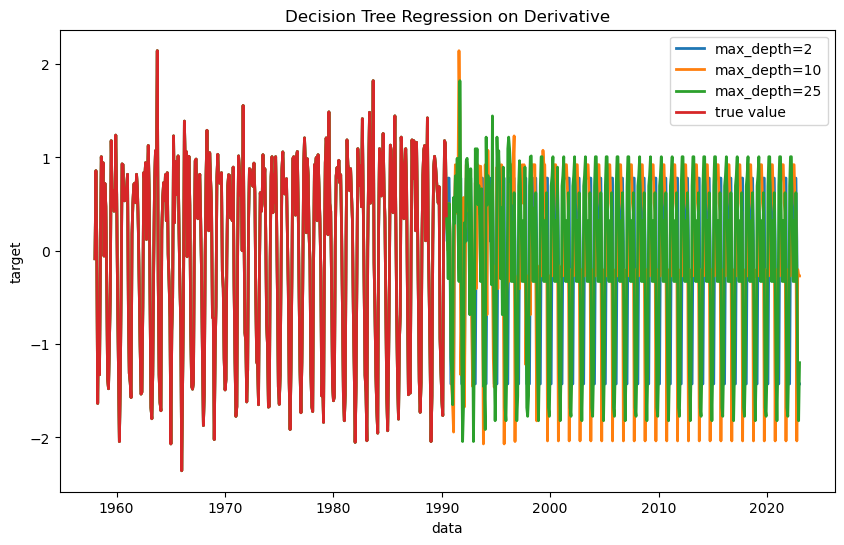

In [108]:
plt.figure(figsize=(10, 6))

# Plots of derivative predictions
plt.plot(dates, future_predictions_3, label=f"max_depth={decistion_tree_3.max_depth}", linewidth=2)
plt.plot(dates, future_predictions_4, label=f"max_depth={decision_tree_4.max_depth}", linewidth=2)
plt.plot(dates, future_predictions_5, label=f"max_depth={decision_tree_5.max_depth}", linewidth=2)
plt.plot(dates[0:len(normalized_train)], normalized_train, label=f"true value", linewidth=2)

plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression on Derivative")
plt.legend()
plt.show()

#### Convert CO2 level differences to absolute CO2 levels

In [109]:
def postprocess_data(output_data, scaler, first_input):
    """
    Function to convert CO2 differences back to absolute CO2 levels
    """
    # Unscale the output
    output = scaler.inverse_transform(np.array(output_data).reshape(-1, 1)).reshape(-1)

    # Get cumulative sum
    output = np.cumsum(output) + first_input

    return output

In [110]:
# Post process data
decoded_3 = postprocess_data(future_predictions_3, scaler, list(co2_data["co2"])[0])
decoded_4 = postprocess_data(future_predictions_4, scaler, list(co2_data["co2"])[0])
decoded_5 = postprocess_data(future_predictions_5, scaler, list(co2_data["co2"])[0])

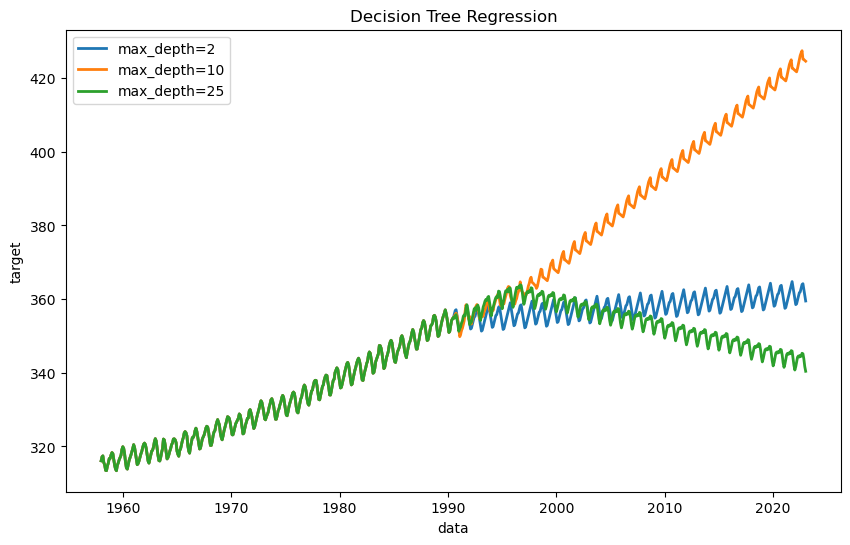

In [111]:
plt.figure(figsize=(10, 6))

plt.plot(dates, decoded_3, label=f"max_depth={decistion_tree_3.max_depth}", linewidth=2)
plt.plot(dates, decoded_4, label=f"max_depth={decision_tree_4.max_depth}", linewidth=2)
plt.plot(dates, decoded_5, label=f"max_depth={decision_tree_5.max_depth}", linewidth=2)

plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

### Recurrent Neural Network (RNN)

#### LSTM - Long Short Term Memory model

In [112]:
# Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [113]:
# Define hyperparameters
TRAIN_WINDOW = 84
FORECAST_WINDOW = 1

input_size = TRAIN_WINDOW # Input layer size
hidden_size = 32 # No of hidden layer neurons
output_size = FORECAST_WINDOW # Output layer size

n_hidden_layers = 1
num_epochs = 75 # Number of training epochs
learning_rate = 0.005

In [114]:
standardScaler = StandardScaler()

# Generate training data for RNN
normalized_train, X_train, y_train, scaler = preprocess_data(
    list(co2_train["co2"]),
    TRAIN_WINDOW,
    standardScaler,
    forecast_window=FORECAST_WINDOW,
    is_test=False,
)

# Generate validation data for RNN
normalized_validation, X_validation, y_validation, scaler = preprocess_data(
    list(co2_validation["co2"]),
    TRAIN_WINDOW,
    standardScaler,
    forecast_window=FORECAST_WINDOW,
    is_test=True,
)

In [115]:
# Convert data to tensors and transfer to GPU (if available)
X_train_tensor = torch.Tensor(np.array(X_train)).to(device)
y_train_tensor = torch.Tensor(np.array(y_train)).to(device)

X_validation_tensor = torch.Tensor(np.array(X_validation)).to(device)
y_validation_tensor = torch.Tensor(np.array(y_validation)).to(device)

In [116]:
# Define the LSTM model
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleLSTM, self).__init__()
        # Define LSTM model
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=n_hidden_layers).to(device)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out

In [117]:
# Instantiate the model, loss function, and optimizer
model = SimpleLSTM(input_size, hidden_size, output_size).to(device)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [118]:
# Training loop
for epoch in range(num_epochs):
    # Forward pass
    output = model(X_train_tensor)

    # Compute the loss
    loss = loss_function(output, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print the loss every 25 epochs
    if (epoch + 1) % 25 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [25/75], Loss: 0.0813
Epoch [50/75], Loss: 0.0556
Epoch [75/75], Loss: 0.0405


In [119]:
# Make predictions on validation data
with torch.no_grad():
    y_predictions_rnn = model(X_validation_tensor)

In [120]:
# Calculate evaluation metrics
mse_of_rnn = mean_squared_error(y_validation_tensor.cpu(), y_predictions_rnn.cpu())

print(f"Validation MSE for RNN: {mse_of_rnn:.4f}")

Validation MSE for RNN: 0.0821


In [121]:
dates = pd.period_range("1958", "2023", freq='M').to_timestamp()
test_inputs = list(normalized_train)

# Number of predictions to make
future_predictions_count = int(np.ceil((len(dates) - len(test_inputs))/FORECAST_WINDOW))

In [122]:
# Iteratively make predictions by moving the training window forward
for i in range(future_predictions_count):
    # Get the last set of input features
    X_test = torch.Tensor(X_train[-1]).view(1, -1).to(device)
    # Get the last target variable
    y_test = torch.Tensor(y_train[-1]).to(device)

    # Predict forecast window forward
    with torch.no_grad():
        y_pred = model(X_test)

    # Append current y values to X
    X_train.append(
        torch.cat((X_test[0][-(TRAIN_WINDOW - FORECAST_WINDOW) :], y_test))
        .cpu()
        .data.numpy()
    )

    # Append prediction to the target values
    y_train.append(y_pred.cpu().data.numpy()[0])

In [123]:
# First value (0) + first values in first training data
#       + y values in y_train (e.g. forecast window values)
predictions = (
    [np.array(0)] +
    [np.array(value) for value in X_train[0]] + 
    [np.array(value) for y in y_train for value in y]
)

#### Convert CO2 level differences to absolute CO2 levels

In [124]:
# Post process data
decoded = postprocess_data(predictions, scaler, list(co2_train["co2"])[0])

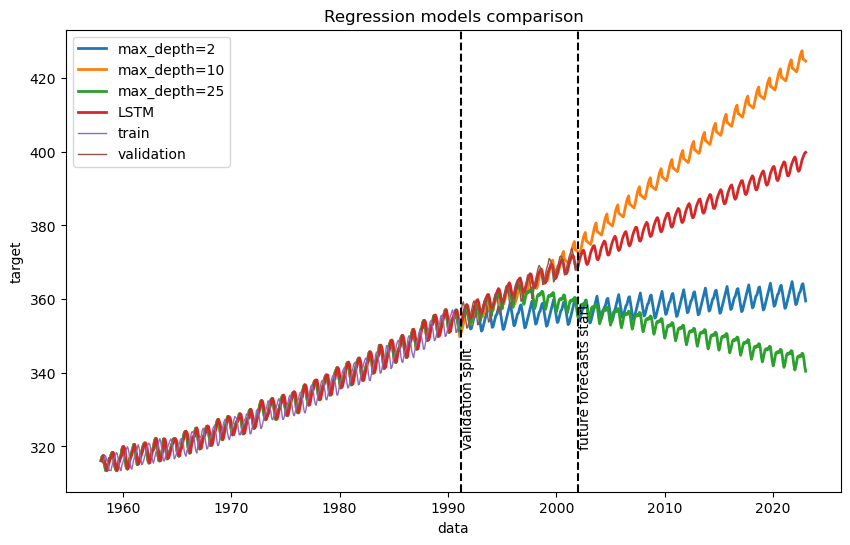

In [125]:
dates = pd.period_range("1958", "2023", freq='M').to_timestamp()
plt.figure(figsize=(10, 6))

# Plots for model predictions
plt.plot(dates, decoded_3, label=f"max_depth={decistion_tree_3.max_depth}", linewidth=2)
plt.plot(dates, decoded_4, label=f"max_depth={decision_tree_4.max_depth}", linewidth=2)
plt.plot(dates, decoded_5, label=f"max_depth={decision_tree_5.max_depth}", linewidth=2)
plt.plot(dates, decoded[:len(dates)], label=f"LSTM", linewidth=2)

# Plot training and validation data
plt.plot(co2_train, label="train", linewidth=1)
plt.plot(co2_validation, label="validation", linewidth=1)

# Vertical dashed line to show the position of validation split
plt.axvline(co2_validation.index[0], linestyle="--", c="k")
plt.text(co2_validation.index[0], 320, 'validation split', rotation=90)

# Vertical dashed line to show the position where future forecasts start
plt.axvline(co2_validation.index[-1], linestyle="--", c="k")
plt.text(co2_validation.index[-1], 320, 'future forecasts start', rotation=90)

plt.xlabel("data")
plt.ylabel("target")
plt.title("Regression models comparison")
plt.legend()
plt.show()

In [126]:
# Print evaluation metrics for comparison
print(f"Validation MSE for Decision Tree with depth 2  : {mse_of_decision_tree_3:.4f}")
print(f"Validation MSE for Decision Tree with depth 10 : {mse_of_decision_tree_4:.4f}")
print(f"Validation MSE for Decision Tree with depth 25 : {mse_of_decision_tree_5:.4f}")
print(f"Validation MSE for Recurrent Neural Network    : {mse_of_rnn:.4f}")

Validation MSE for Decision Tree with depth 2  : 0.1530
Validation MSE for Decision Tree with depth 10 : 0.1454
Validation MSE for Decision Tree with depth 25 : 0.1770
Validation MSE for Recurrent Neural Network    : 0.0821
